In [1]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from dataclasses import dataclass
import numpy as np

import jax
import jax.numpy as jnp
import os

from tqdm import tqdm

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

Pricing European call option under Heston dynamics

The Heston model under EMM $\mathbb{Q}$ reads:

$$\begin{array}{l}
\mathrm{d} S(t)=r S(t) \mathrm{d} t+\sqrt{v(t)} S(t) \mathrm{d} W_s^{\mathbb{Q}}(t), \quad S\left(t_0\right)=S_0>0 \\
\mathrm{~d} v(t)=\kappa(\bar{v}-v(t)) \mathrm{d} t+\gamma \sqrt{v(t)} \mathrm{d} W_v^{\mathbb{Q}}(t), \quad v\left(t_0\right)=v_0>0 .
\end{array}$$

Where Brownian motions are correlated $dW_s^{\mathbb{Q}}(t)dW_v^{\mathbb{Q}}(t) = \rho dt$

In order to simulate $S(t)$ process we use Cholesky decomposition to represent correlated Brownian motions $W_s^{\mathbb{Q}}(t), \; W_v^{\mathbb{Q}}(t)$ using independent Brownian motions $\widetilde{W}_s^{\mathbb{Q}}(t), \; \widetilde{W}_v^{\mathbb{Q}}(t)$ in the following way:

$dW_s^{\mathbb{Q}}(t) = \rho d\widetilde{W}_v^{\mathbb{Q}}(t) + \sqrt{1 - \rho^2} d\widetilde{W}_s^{\mathbb{Q}}(t)$

$dW_v^{\mathbb{Q}}(t) = d\widetilde{W}_v^{\mathbb{Q}}(t)$

Under such transformation BMs are still correlated $dW_s^{\mathbb{Q}}(t)dW_v^{\mathbb{Q}}(t) = \rho dt$.

Then the model reads:

$$\begin{array}{l}
\mathrm{d} S(t)=r S(t) \mathrm{d} t+\sqrt{v(t)} S(t) \left[\rho d\widetilde{W}_v^{\mathbb{Q}}(t) + \sqrt{1 - \rho^2} d\widetilde{W}_s^{\mathbb{Q}}(t)\right] , \quad S\left(t_0\right)=S_0>0 \\
\mathrm{~d} v(t)=\kappa(\bar{v}-v(t)) \mathrm{d} t+\gamma \sqrt{v(t)} d\widetilde{W}_v^{\mathbb{Q}}(t), \quad v\left(t_0\right)=v_0>0 .
\end{array}$$


To simulate variance process $v(t)$ we use QR scheme.

In [2]:
S = 100.0
T = 1.0
K = 100.0
r = 0.03

key = jax.random.key(37)

In [3]:
@dataclass
class HestonParams:
    kappa: float
    mean: float
    gamma: float
    rho:float
    v0:float

    def to_array(self):
        return np.array([self.kappa, self.mean, self.gamma, self.rho, self.v0])

heston_params = HestonParams(
    kappa = 1.5768,
    mean = 0.0898,
    gamma = 0.3551,
    rho = -0.5711,
    v0 = 0.0575
)

In [4]:
@jax.jit
def get_next_cir_value(kappa, mean, gamma, rho, v0, v_prev, dt, z1, z2):
    c_bar = gamma**2/4/kappa*(1 - jnp.exp(-kappa*dt))
    kappa_bar = 4*kappa*jnp.exp(-kappa*dt)/gamma**2/(1 - jnp.exp(-kappa*dt))*v_prev
    df = 4*kappa*mean/gamma**2
    mu = c_bar*(df + kappa_bar)
    var = c_bar**2*(2*df + 4*kappa_bar)
    b = jnp.sqrt(2*mu**2/var - 1 + jnp.sqrt(2*mu**2/var)*jnp.sqrt(2*mu**2/var - 1))
    a = mu/(1 + b**2)
    c = (var/mu**2 - 1 )/(var/mu**2 + 1)
    d = (1 - c)/mu
    flag = var/mu**2 <= 1.5
    return a*(b+z1)**2*flag + jnp.log((1-c)/(1-z2))/d*(z2>c)*(1-flag)

@jax.jit
def get_next_logprice_value(kappa, mean, gamma, rho, v0, T, s_prev, r, v_prev, v_curr, dt, z3):
    k0 = (r - rho/gamma*kappa*mean)*dt
    k1 = (rho/gamma*kappa - 0.5)*dt - rho/gamma
    k2 = rho/gamma
    k3 = (1 - rho**2)*dt
    return s_prev + k0 + k1*v_prev + k2*v_curr + jnp.sqrt(k3*v_prev)*z3

In [5]:
def get_terminal_prices(kappa, mean, gamma, rho, v0, T, S, r, N_paths, N_steps, key):
    dt = T/(N_steps-1)

    def step(carry, key):
        v_prev, s_prev = carry
        key1, key2, key3 = jax.random.split(key, 3)
        z1 = jax.random.normal(key1, (N_paths,))
        z2 = jax.random.uniform(key2, (N_paths,))
        z3 = jax.random.normal(key3, (N_paths,))

        v_next = get_next_cir_value(kappa, mean, gamma, rho, v0, v_prev, dt, z1, z2)
        s_next = get_next_logprice_value(kappa, mean, gamma, rho, v0, T, s_prev, r, v_prev, v_next, dt, z3)
        return (v_next, s_next), s_next

    keys = jax.random.split(key, N_steps-1)
    v_init = jnp.full(N_paths, v0)
    s_init = jnp.full(N_paths, jnp.log(S))
    (_, terminal_logprices), _ = jax.lax.scan(step, (v_init, s_init), keys)

    return jnp.exp(terminal_logprices)

get_terminal_prices = jax.jit(get_terminal_prices, static_argnums=(8, 9))

In [6]:
%%time

N_paths = 500_000
N_steps = 500
terminal_prices = get_terminal_prices(*heston_params.to_array(), T, S, r, N_paths, N_steps, key)

CPU times: user 2.76 s, sys: 176 ms, total: 2.94 s
Wall time: 6.81 s


Given simulated asset price paths under EMM, we calculate price of a European option as follows:

$V(T, S) = e^{-rT}\mathbb{E}_{\mathbb{Q}}\left[V(0, S_T)|S_0 = S \right]\approx e^{-rT} \frac{1}{N_{paths}} \sum_\limits{i = 1}^{N_{paths}}V(0, S_T^{(i)})$

$V(T, s)$ - option value, $T$ - time to maturity, $s$ - current asset price;


For options greeks we use pathwise(PW) approach for delta and finite difference(FD) method for gamma and vega.

Delta: $\Delta = \frac{\partial V}{\partial S(t_0)} = e^{-r(T-t_0)}\mathbb{E}_{\mathbb{Q}}\left[\frac{S(T)}{S(t_0)}I(S(T) > K)|\mathcal{F}(t_0) \right]$

Gamma: $\frac{\partial^2 V}{\partial S(t_0)^2} = \frac{\partial \Delta}{\partial S(t_0)} = \frac{\Delta(S(t_0) + dS) - \Delta(S(t_0) - dS)}{2dS}$

Vega: $\frac{\partial V}{\partial v_0} = \frac{V(v_0 + dv_0) - V(v_0 - dv_0)}{2dv_0}$

In [7]:
@jax.jit
def mc_price(K, r, T, terminal_prices):
    return jnp.exp(-r*T)*jnp.mean(jnp.maximum(terminal_prices - K, 0))


@jax.jit
def delta_pw(K, r, T, S, terminal_prices):
    return jnp.exp(-r*T)*jnp.mean(terminal_prices*(terminal_prices>K))/S

@jax.jit
def gamma_fd(K, r, T, S, rel):
    terminal_prices_0 = get_terminal_prices(*heston_params.to_array(), T, S*(1 - rel), r, N_paths, N_steps, key)
    terminal_prices_1 = get_terminal_prices(*heston_params.to_array(), T, S*(1 + rel), r, N_paths, N_steps, key)
    mc_deltas_0 = delta_pw(K, r, T, S*(1-rel), terminal_prices_0)
    mc_deltas_1 = delta_pw(K, r, T, S*(1+rel), terminal_prices_1)

    return (mc_deltas_1 - mc_deltas_0)/2/S/rel

@jax.jit
def vega_fd(K, r, T, rel):
    params_0, params_1 = jnp.array(heston_params.to_array()), jnp.array(heston_params.to_array())
    params_0 = params_0.at[-1].set(params_0[-1]*(1-rel))
    params_1 = params_1.at[-1].set(params_1[-1]*(1+rel))
    terminal_prices_0 = get_terminal_prices(*params_0, T, S, r, N_paths, N_steps, key)
    terminal_prices_1 = get_terminal_prices(*params_1, T, S, r, N_paths, N_steps, key)
    mc_prices_0 = mc_price(K, r, T, terminal_prices_0)
    mc_prices_1 = mc_price(K, r, T, terminal_prices_1)

    return (mc_prices_1 - mc_prices_0)/2/rel/heston_params.to_array()[-1]

In [8]:
NK = 100
NT = 50
K_mesh, T_mesh = np.meshgrid(np.linspace(0.5*K, 1.5*K, NK), np.linspace(0.1, 3, NT))
rel = 0.05

def price_greeks_surface(K_mesh, T_mesh):
    Prices = jnp.zeros((NT, NK))
    Deltas = jnp.zeros((NT, NK))
    Gammas = jnp.zeros((NT, NK))
    Vegas = jnp.zeros((NT, NK))
    for i in tqdm(np.arange(NT), desc = 'Outer loop', leave = True, position = 0, dynamic_ncols = True):
        terminal_prices = get_terminal_prices(*heston_params.to_array(), T_mesh[i, 0], S, r, N_paths, N_steps, key)
        Prices = Prices.at[i, :].set(jax.vmap(mc_price, in_axes=(0, None, None, None))(K_mesh[i, :], r, T_mesh[i, 0], terminal_prices))
        Deltas = Deltas.at[i, :].set(jax.vmap(delta_pw, in_axes=(0, None, None, None, None))(K_mesh[i, :], r, T_mesh[i, 0], S, terminal_prices))
        Gammas = Gammas.at[i, :].set(jax.vmap(gamma_fd, in_axes=(0, None, None, None, None))(K_mesh[i, :], r, T_mesh[i, 0], S, rel))
        Vegas = Vegas.at[i, :].set(jax.vmap(vega_fd, in_axes=(0, None, None, None))(K_mesh[i, :], r, T_mesh[i, 0], rel))

    return Prices, Deltas, Gammas, Vegas

In [9]:
Prices, Deltas, Gammas, Vegas = price_greeks_surface(K_mesh, T_mesh)

Outer loop: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


In [10]:
print(f'Underlying price = {S}', f'N_paths = {N_paths}', f'N_steps = {N_steps}')
fig = make_subplots(rows = 2, cols = 2, specs = \
                    [[{'type' : 'surface'}, {'type' : 'surface'}], [{'type' : 'surface'}, {'type' : 'surface'}]],\
                    subplot_titles = ('Price','PW Delta','FD Gamma','FD Vega'),
                    horizontal_spacing = 0.05,
                    vertical_spacing=0.1
                )


fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = Prices, showscale = False), row = 1, col = 1)
fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = Deltas, showscale = False), row = 1, col = 2)
fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = Gammas, showscale = False), row = 2, col = 1)
fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = Vegas, showscale = False), row = 2, col = 2)

fig.update_layout(
    height=1200,
    width=1200,
    scene1 = dict(zaxis_title = 'Price', xaxis_title = 'Strike', yaxis_title = 'Maturity'),
    scene2 = dict(zaxis_title = 'Delta',xaxis_title = 'Strike', yaxis_title = 'Maturity'),
    scene3 = dict(zaxis_title = 'Gamma',xaxis_title = 'Strike', yaxis_title = 'Maturity'),
    scene4 = dict(zaxis_title = 'Vega',xaxis_title = 'Strike', yaxis_title = 'Maturity'),

)
fig.show()

Underlying price = 100.0 N_paths = 500000 N_steps = 500


Now let's compute greeks using JAX autograd capabilities

To be able to compute second order greeks, such as gamma, we need a differentiable payoff. To achive this we approximate european payoff in a following way:

$\text{max}(S-K, 0) \approx \frac{\ln(1+e^{\omega(S-K)})}{\omega}$, where $\omega$ - smoothness parameter(lower $\omega$  equals higher smoothness).

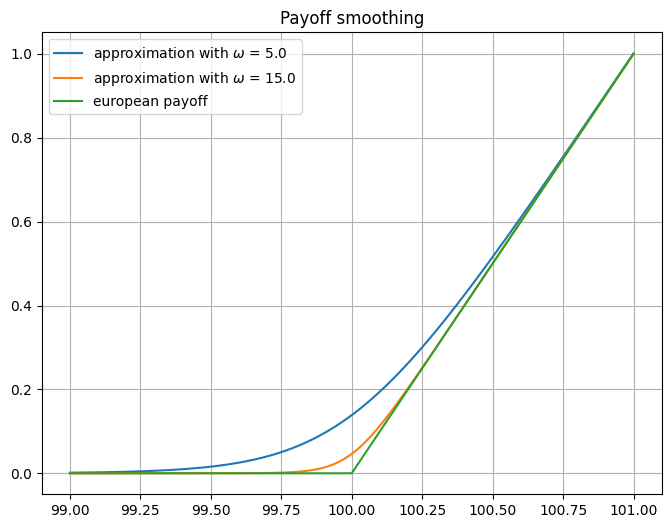

In [11]:
x = np.linspace(K*0.99, K*1.01, 1000)
w1 = 5.0
w2 = 15.0

plt.figure(figsize = (8, 6))
plt.plot(x, np.log(1 + np.exp(w1*(x- K)))/w1, label = f'approximation with $\\omega$ = {w1}')
plt.plot(x, np.log(1 + np.exp(w2*(x- K)))/w2, label = f'approximation with $\\omega$ = {w2}')
plt.plot(x, np.maximum(0, x-K), label = 'european payoff')
plt.grid()
plt.title('Payoff smoothing')
plt.legend()
plt.show()

In [12]:
smoothness = 15.0
def calc_mc_price(kappa, mean, gamma, rho, v0, K, T, S, r, N_paths, N_steps, key):
    terminal_prices = get_terminal_prices(kappa, mean, gamma, rho, v0, T, S, r, N_paths, N_steps, key)
    return jnp.exp(-r*T)*jnp.mean(jax.nn.softplus(smoothness * (terminal_prices - K)) / smoothness)

calc_mc_price = jax.jit(calc_mc_price, static_argnums=(9, 10))

In [13]:
delta_ = jax.grad(calc_mc_price, argnums=7)
gamma_ = jax.grad(delta_, argnums=7)
vega_ = jax.jacfwd(calc_mc_price, argnums=4)


price_delta = jax.value_and_grad(calc_mc_price, argnums=7)

In [14]:
%%time
price_1, delta_1 = price_delta(*heston_params.to_array(), K, T, S, r, N_paths, N_steps, key)
gamma_1 = gamma_(*heston_params.to_array(), K, T, S, r, N_paths, N_steps, key)
vega_1 = vega_(*heston_params.to_array(), K, T, S, r, N_paths, N_steps, key)


print("Price:", price_1)
print("Delta:", delta_1)
print("Gamma:", gamma_1)
print("Vega:", vega_1)

Price: 11.871991
Delta: 0.6397435
Gamma: 0.014473425
Vega: 34.827843
CPU times: user 7.12 s, sys: 154 ms, total: 7.27 s
Wall time: 7.47 s


In [15]:
NK = 100
NT = 50
K_mesh, T_mesh = np.meshgrid(np.linspace(0.5*K, 1.5*K, NK), np.linspace(0.1, 3, NT))

in_axes = (None, None, None, None, None, 0, None, None, None, None, None, None)
def mc_mesh(K_mesh, T_mesh):
    Prices = jnp.zeros((NT, NK))
    Deltas = jnp.zeros((NT, NK))
    Gammas = jnp.zeros((NT, NK))
    Vegas = jnp.zeros((NT, NK))
    for i in tqdm(np.arange(NT), desc = 'Outer loop', leave = True, position = 0, dynamic_ncols = True):
        price_tmp, delta_tmp = jax.vmap(price_delta, in_axes = in_axes)(*heston_params.to_array(), K_mesh[i,:], T_mesh[i,0], S, r, N_paths, N_steps, key)
        Prices = Prices.at[i,:].set(price_tmp)
        Deltas = Deltas.at[i,:].set(delta_tmp)
        Gammas = Gammas.at[i,:].set(jax.vmap(gamma_, in_axes = in_axes)(*heston_params.to_array(), K_mesh[i,:], T_mesh[i,0], S, r, N_paths, N_steps, key))
        Vegas = Vegas.at[i,:].set(jax.vmap(vega_, in_axes = in_axes)(*heston_params.to_array(), K_mesh[i,:], T_mesh[i,0], S, r, N_paths, N_steps, key))
    return Prices, Deltas, Gammas, Vegas

In [16]:
prices, deltas, gammas, vegas = mc_mesh(K_mesh, T_mesh)

Outer loop: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


In [17]:
print(f'Underlying price = {S}', f'N_paths = {N_paths}', f'N_steps = {N_steps}')
fig = make_subplots(rows = 2, cols = 2, specs = \
                    [[{'type' : 'surface'}, {'type' : 'surface'}], [{'type' : 'surface'}, {'type' : 'surface'}]],\
                    subplot_titles = ('Price','AD Delta','AD Gamma','AD Vega'),
                    horizontal_spacing = 0.05,
                    vertical_spacing=0.1
                )


fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = prices, showscale = False), row = 1, col = 1)
fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = deltas, showscale = False), row = 1, col = 2)
fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = gammas, showscale = False), row = 2, col = 1)
fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = vegas, showscale = False), row = 2, col = 2)

fig.update_layout(
    height=1200,
    width=1200,
    scene1 = dict(zaxis_title = 'Price', xaxis_title = 'Strike', yaxis_title = 'Maturity'),
    scene2 = dict(zaxis_title = 'Delta',xaxis_title = 'Strike', yaxis_title = 'Maturity'),
    scene3 = dict(zaxis_title = 'Gamma',xaxis_title = 'Strike', yaxis_title = 'Maturity'),
    scene4 = dict(zaxis_title = 'Vega',xaxis_title = 'Strike', yaxis_title = 'Maturity'),

)
fig.show()

Underlying price = 100.0 N_paths = 500000 N_steps = 500


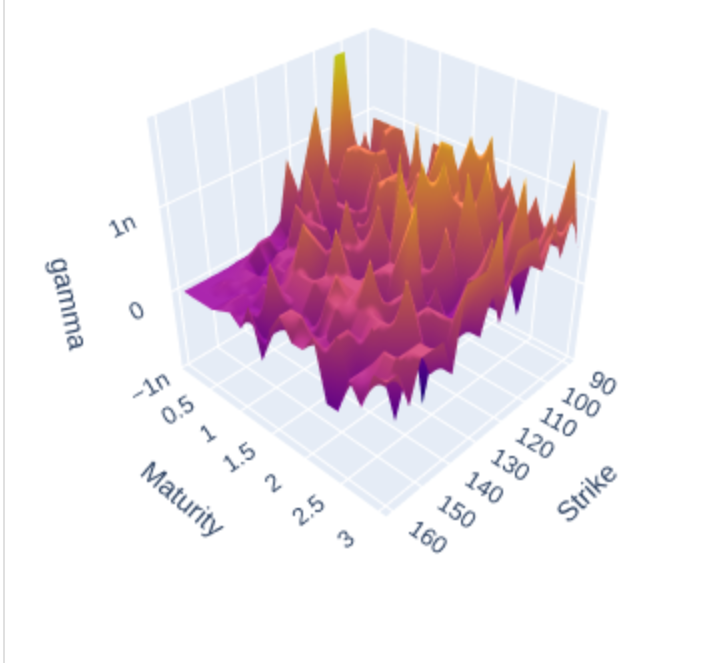 - options "Gamma" without smoothing.

First order Greeks does not have any problem being computed without smooth payofff.

Comparison of greeks computation methods:

In [18]:
fig = make_subplots(rows = 2, cols = 2, specs = \
                    [[{'type' : 'surface'}, {'type' : 'surface'}], [{'type' : 'surface'}, {'type' : 'surface'}]],\
                    subplot_titles = ('Price','PW Delta - AD Delta','FD Gamma - AD Gamma','FD Vega - AD Vega'),
                    horizontal_spacing = 0.05,
                    vertical_spacing=0.1
                )

fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = (Prices - prices), showscale = False), row = 1, col = 1)
fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = (Deltas - deltas), showscale = False), row = 1, col = 2)
fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = (Gammas - gammas), showscale = False), row = 2, col = 1)
fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = (Vegas - vegas), showscale = False), row = 2, col = 2)

fig.update_layout(
    height=1200,
    width=1200,
    scene1 = dict(zaxis_title = 'Price', xaxis_title = 'Strike', yaxis_title = 'Maturity'),
    scene2 = dict(zaxis_title = 'Delta',xaxis_title = 'Strike', yaxis_title = 'Maturity'),
    scene3 = dict(zaxis_title = 'Gamma',xaxis_title = 'Strike', yaxis_title = 'Maturity'),
    scene4 = dict(zaxis_title = 'Vega',xaxis_title = 'Strike', yaxis_title = 'Maturity'),

)
fig.show()

Time to maturity = 0.1


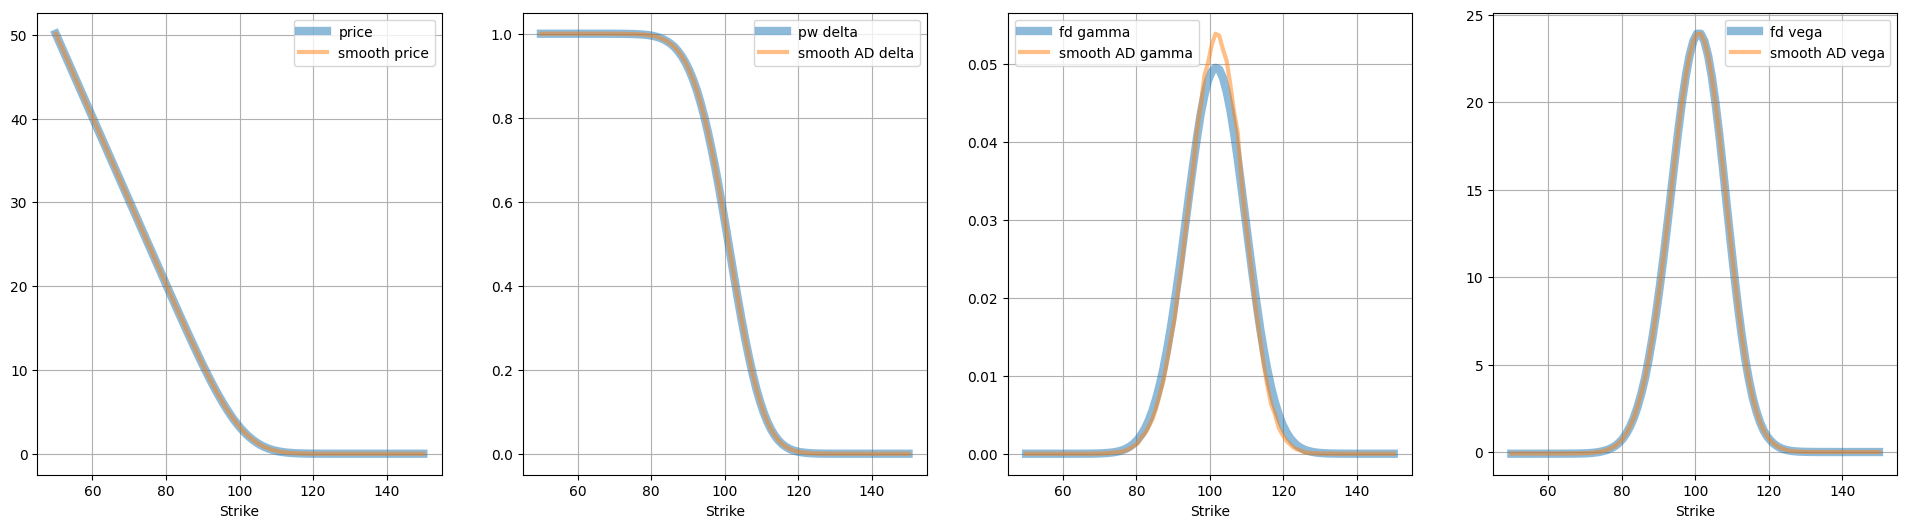

Time to maturity = 0.8102


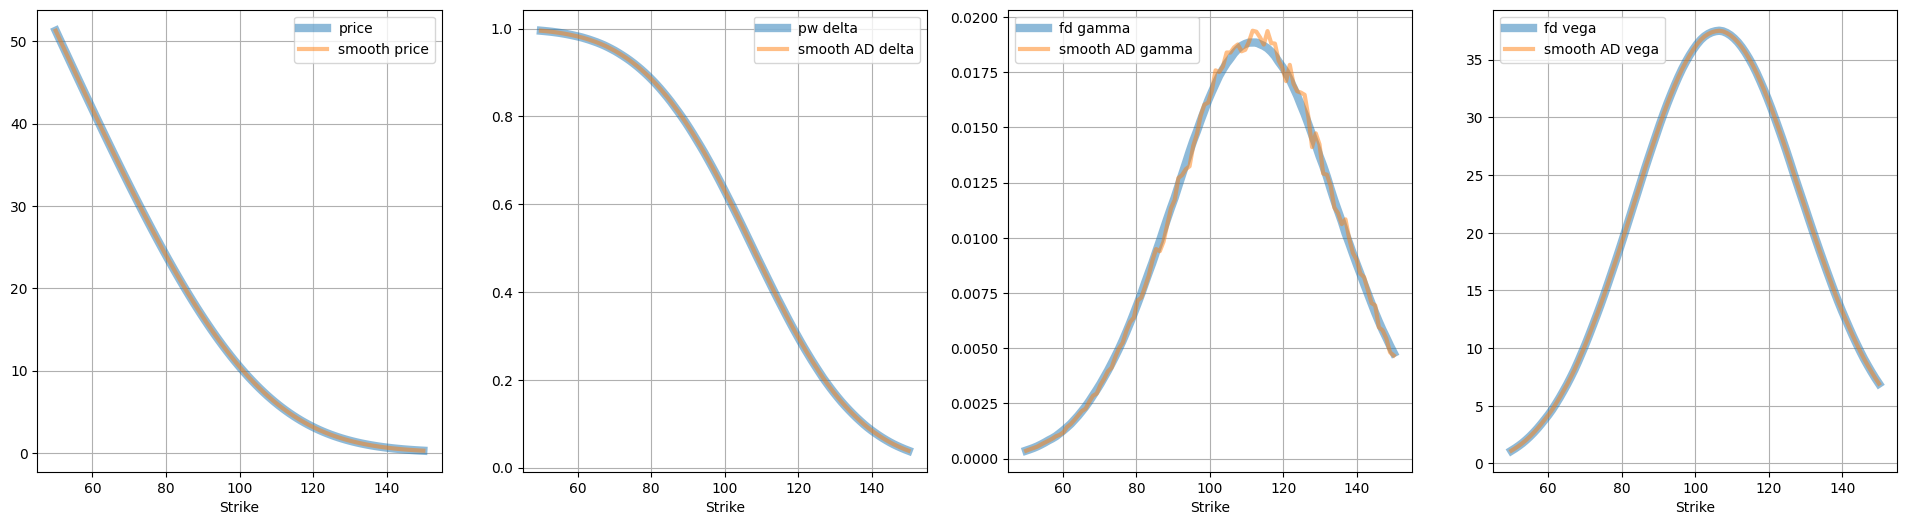

Time to maturity = 1.52


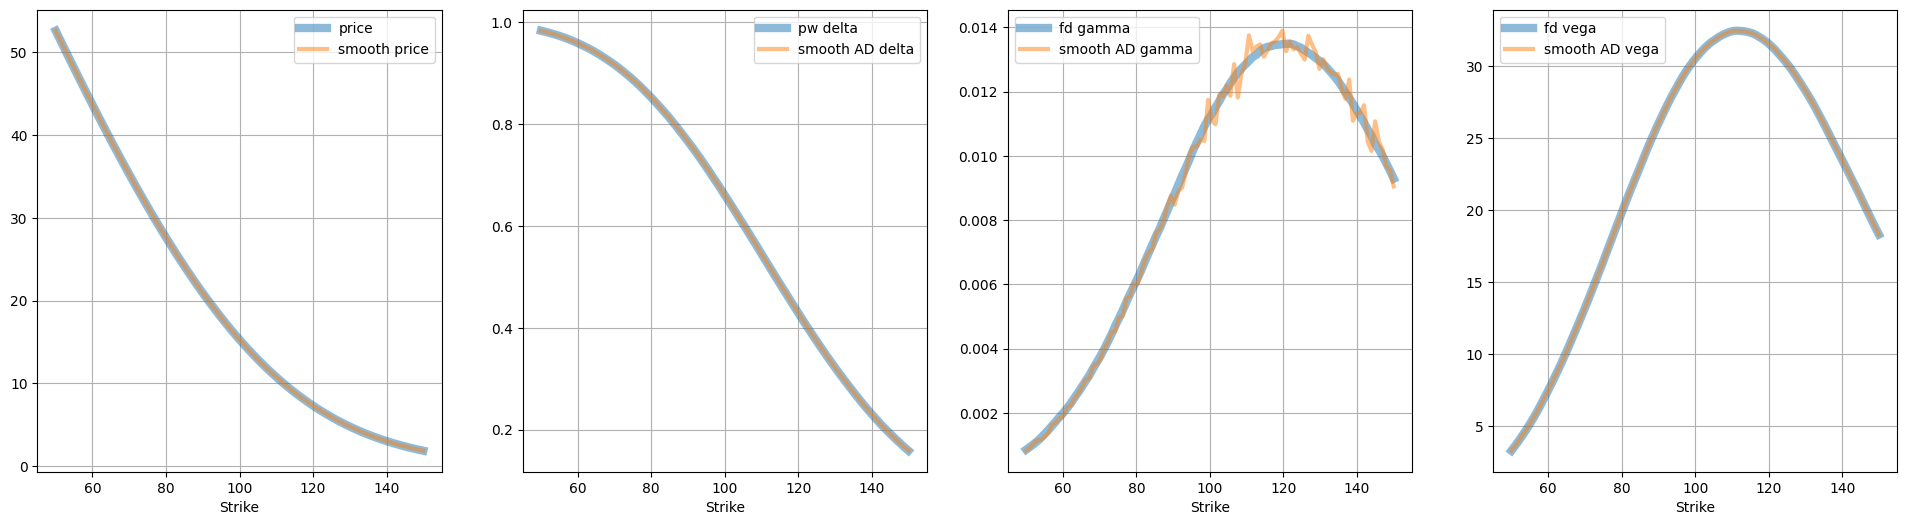

Time to maturity = 2.231


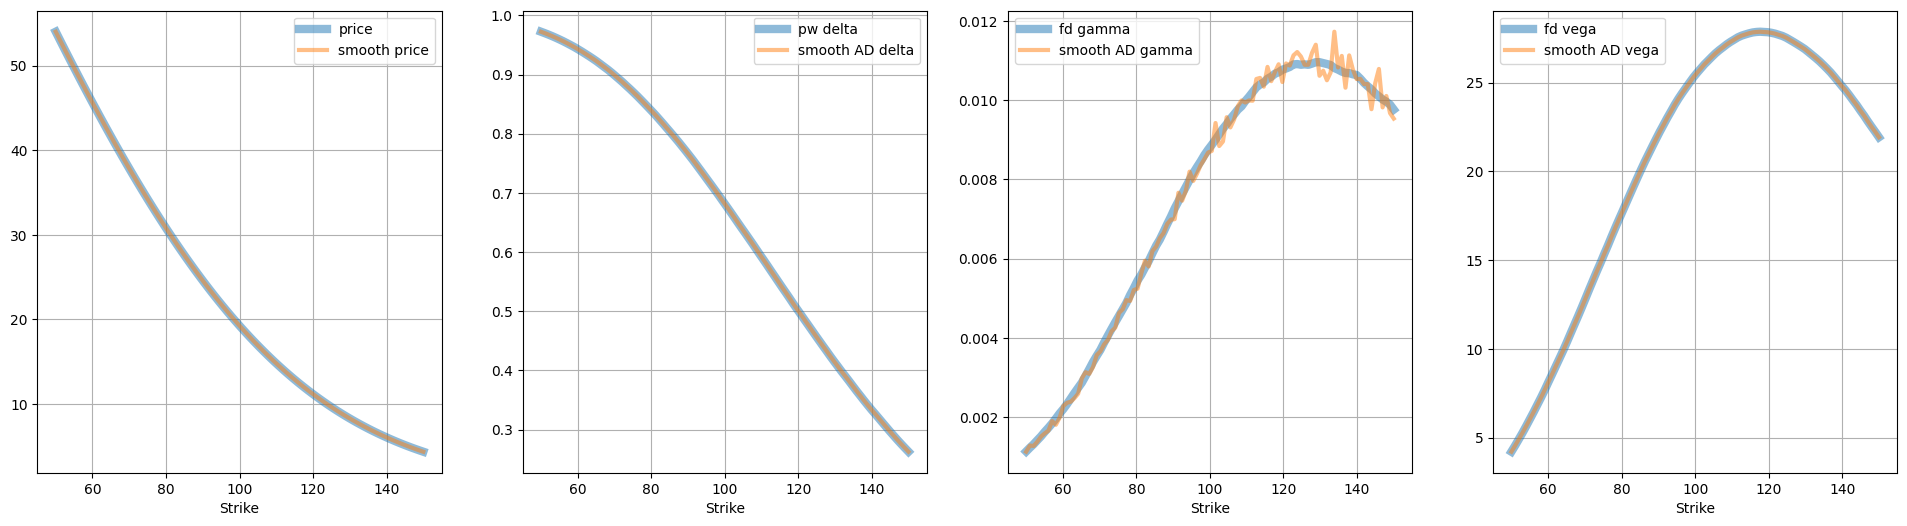

Time to maturity = 2.941


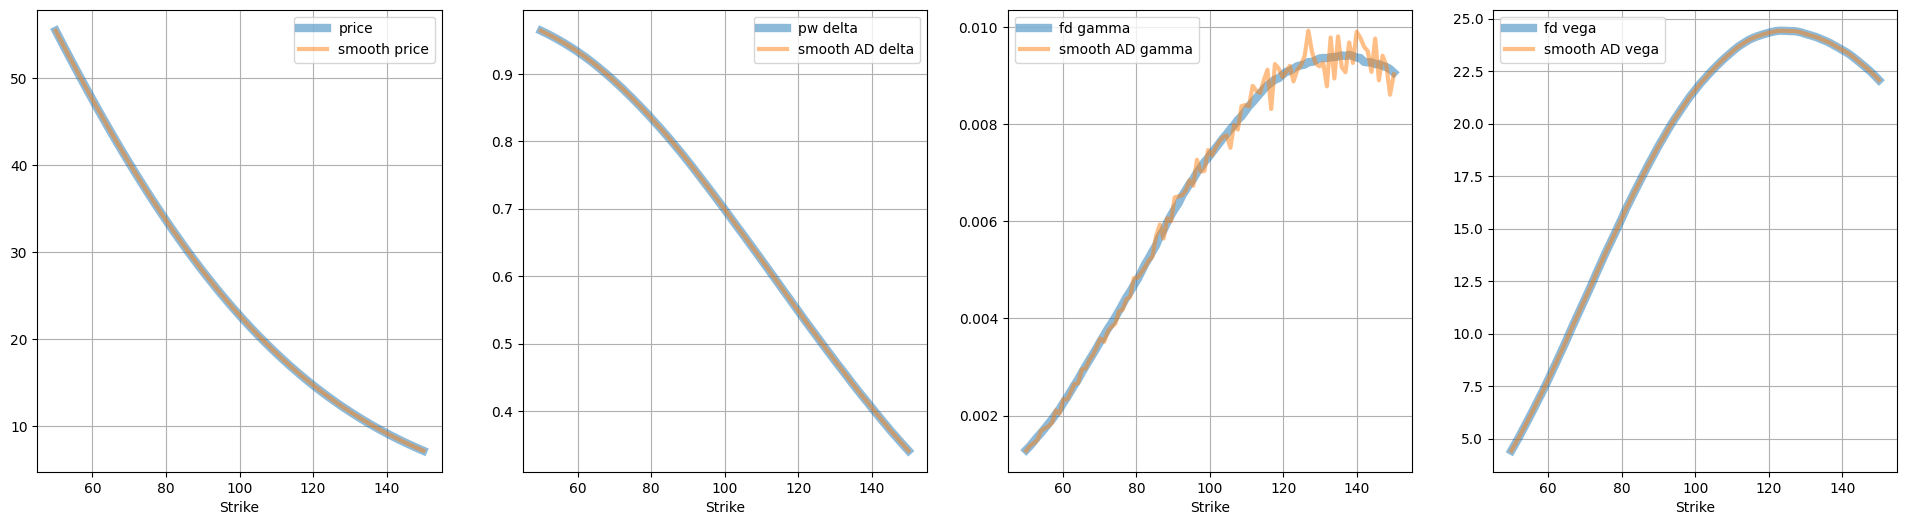

In [19]:
for i in range(0, NT, NT//4):
  print(f'Time to maturity = {T_mesh[i, 0]:.4}')
  fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (24, 6))

  axes[0].plot(K_mesh[i, :], Prices[i, :], lw = 6, alpha = 0.5, label = 'price')
  axes[0].plot(K_mesh[i, :], prices[i, :], lw = 3, alpha = 0.5, label = 'smooth price')
  axes[1].plot(K_mesh[i, :], Deltas[i, :], lw = 6, alpha = 0.5, label = 'pw delta')
  axes[1].plot(K_mesh[i, :], deltas[i, :], lw = 3, alpha = 0.5, label = 'smooth AD delta')
  axes[2].plot(K_mesh[i, :], Gammas[i, :], lw = 6, alpha = 0.5, label = 'fd gamma')
  axes[2].plot(K_mesh[i, :], gammas[i, :], lw = 3, alpha = 0.5, label = 'smooth AD gamma')
  axes[3].plot(K_mesh[i, :], Vegas[i, :], lw = 6, alpha = 0.5, label = 'fd vega')
  axes[3].plot(K_mesh[i, :], vegas[i, :], lw = 3, alpha = 0.5, label = 'smooth AD vega')

  for ax in axes:
    ax.set_xlabel('Strike')
    ax.grid()
    ax.legend()

  plt.show()

### COS method

In the Hedge part of the notebook there is a need to compute options delta, vega for each path for each timestep.
So, in order to make this task feasible we need to compute greeks and prices super fast.

In order to achieve this the COS method for pricing European otpion under Heston model is employed.

In [20]:
from numba import njit
import cmath as cmath
import numba
import math

In [21]:
@njit
def ChF(kappa, mean, gamma, rho, v0, T, r, u):
    i = complex(0, 1)
    D1 = cmath.sqrt((kappa - i*rho*gamma*u)**2 + (u**2 + i*u)*gamma**2)
    g = (kappa - i*rho*gamma*u - D1)/(kappa - i*rho*gamma*u + D1)
    return cmath.exp(i*u*r*T + v0/gamma**2*(1 - cmath.exp(-D1*T))/(1 - g*cmath.exp(-D1*T))*(kappa-i*rho*gamma*u - D1))*\
        cmath.exp(kappa*mean/gamma**2*( T*(kappa - i*rho*gamma*u - D1) - 2*cmath.log((1 - g*cmath.exp(-D1*T))/(1-g))))

@njit
def Chi_k(k, c, d, a, b):
    p1 = math.cos(k*math.pi*(d-a)/(b-a))*math.exp(d)
    p2 = math.cos(k*math.pi*(c-a)/(b-a))*math.exp(c)
    p3 = k*math.pi/(b-a)*math.sin(k*math.pi*(d-a)/(b-a))*math.exp(d)
    p4 = k*math.pi/(b-a)*math.sin(k*math.pi*(c-a)/(b-a))*math.exp(c)
    return (1 + (k*math.pi/(b-a))**2)**(-1)*(p1 - p2 + p3 - p4)


@njit
def Psi_k(k, c, d, a, b):
    if k == 0:
        return d - c
    else:
        p1 = math.sin(k*math.pi*(d-a)/(b-a))
        p2 = math.sin(k*math.pi*(c-a)/(b-a))
        return (b-a)/k/math.pi*(p1-p2)

@njit
def Uk(k, a, b, call):
    return 2/(b-a)*(Chi_k(k, 0, b, a, b) - Psi_k(k, 0, b, a, b)) if call == True else 2/(b-a)*(-Chi_k(k, a, 0, a, b) + Psi_k(k, a, 0, a, b))

In [22]:
%%time
ChF(*heston_params.to_array(), T, r, 2)

CPU times: user 1.6 s, sys: 90.8 ms, total: 1.69 s
Wall time: 1.72 s


(0.8588134550725893+0.005724969957673243j)

In [23]:
@numba.vectorize(['float64(float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, bool_)'], fastmath = True, target = 'parallel')
def calc_vanilla_price_cos(kappa, mean, gamma, rho, v0, T, S, r, K, a, b, N, call):
    i = complex(0, 1)
    res = 0.0
    for j in range(N):
        res +=  (1 - 0.5*(j == 0))*(ChF(kappa, mean, gamma, rho, v0, T, r, j*math.pi/(b-a))*Uk(j, a, b, call)*cmath.exp(i*j*math.pi*(math.log(S/K)-a)/(b-a))).real
    res *= K*math.exp(-r*T)
    return res

@numba.vectorize(['float64(float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, bool_)'], fastmath = True, target = 'parallel')
def calc_vanilla_delta_cos(kappa, mean, gamma, rho, v0, T, S, r, K, a, b, N, call):
    i = complex(0, 1)
    res = 0.0
    for j in range(N):
            res +=  (1 - 0.5*(j == 0))*(ChF(kappa, mean, gamma, rho, v0, T, r, j*math.pi/(b-a))*Uk(j, a, b, call)*(i*j*math.pi/(b-a)/S)*cmath.exp(i*j*math.pi*(math.log(S/K)-a)/(b-a))).real
    res *= K*math.exp(-r*T)
    return res

@numba.vectorize(['float64(float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, bool_)'], fastmath = True, target = 'parallel')
def calc_vanilla_gamma_cos(kappa, mean, gamma, rho, v0, T, S, r, K, a, b, N, call):
    i = complex(0, 1)
    res = 0.0
    for j in range(N):
            res +=  (1 - 0.5*(j == 0))*(ChF(kappa, mean, gamma, rho, v0, T, r, j*math.pi/(b-a))*Uk(j, a, b, call)*((i*j*math.pi/(b-a)/S)**2 - (i*j*math.pi/(b-a)/S**2))*cmath.exp(i*j*math.pi*(math.log(S/K)-a)/(b-a))).real
    res *= K*math.exp(-r*T)
    return res

@njit
def C_bar(kappa, mean, gamma, rho, v0, T, u):
    i = complex(0, 1)
    D1 = cmath.sqrt((kappa - i*rho*gamma*u)**2 + (u**2 + i*u)*gamma**2)
    g = (kappa - i*rho*gamma*u - D1)/(kappa - i*rho*gamma*u + D1)
    a1 = -0.5*(u**2 + i*u)
    a2 = kappa - gamma*rho*i*u
    a3 = 0.5*gamma**2
    r_ = 0.5/a3*(a2 - D1)
    return (1 - cmath.exp(-D1*T))/(1 - g*cmath.exp(-D1*T))*r_

@numba.vectorize(['float64(float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, float64, bool_)'], fastmath = True, target = 'parallel')
def calc_vanilla_vega_cos(kappa, mean, gamma, rho, v0 , T, S, r, K, a, b, N, call):
    i = complex(0, 1)
    res = 0.0
    for j in range(N):
            res +=  (1 - 0.5*(j == 0))*(ChF(kappa, mean, gamma, rho, v0, T, r, j*math.pi/(b-a))*Uk(j, a, b, call)*C_bar(kappa, mean, gamma, rho, v0, T, j*math.pi/(b-a))*cmath.exp(i*j*math.pi*(math.log(S/K)-a)/(b-a))).real
    res *= K*math.exp(-r*T)
    return res

In [24]:
%%time
a = -5
b = 5
N = 300
calc_vanilla_delta_cos(*heston_params.to_array(), T, S, r, K, a, b, N, True)

CPU times: user 752 µs, sys: 0 ns, total: 752 µs
Wall time: 553 µs


np.float64(0.6407646995788587)

In [25]:
%%time

NK = 100
NT = 25
K_mesh, T_mesh = np.meshgrid(np.linspace(0.5*K, 1.5*K, NK), np.linspace(0.1, 3, NT))

price_cos = calc_vanilla_price_cos(*heston_params.to_array(), T_mesh, S, r, K_mesh, a, b, N, True)
delta_cos = calc_vanilla_delta_cos(*heston_params.to_array(), T_mesh, S, r, K_mesh, a, b, N, True)
gamma_cos = calc_vanilla_gamma_cos(*heston_params.to_array(), T_mesh, S, r, K_mesh, a, b, N, True)
vega_cos = calc_vanilla_vega_cos(*heston_params.to_array(), T_mesh, S, r, K_mesh, a, b, N, True)

CPU times: user 1.48 s, sys: 3.97 ms, total: 1.49 s
Wall time: 775 ms


In [26]:
fig = make_subplots(rows = 2, cols = 2, specs = \
                    [[{'type' : 'surface'}, {'type' : 'surface'}], [{'type' : 'surface'}, {'type' : 'surface'}]],\
                    subplot_titles = ('COS Price','COS Delta','COS Gamma','COS Vega'),
                    horizontal_spacing = 0.05,
                    vertical_spacing=0.1
                )


fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = price_cos, showscale = False), row = 1, col = 1)
fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = delta_cos, showscale = False), row = 1, col = 2)
fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = gamma_cos, showscale = False), row = 2, col = 1)
fig.add_trace(go.Surface(x = K_mesh, y = T_mesh, z = vega_cos, showscale = False), row = 2, col = 2)

fig.update_layout(
    title_text='Heston vanilla price with S = 100',
    height=1200,
    width=1200,
    scene1 = dict(zaxis_title = 'Price', xaxis_title = 'Strike', yaxis_title = 'Maturity'),
    scene2 = dict(zaxis_title = 'Delta',xaxis_title = 'Strike', yaxis_title = 'Maturity'),
    scene3 = dict(zaxis_title = 'Gamma',xaxis_title = 'Strike', yaxis_title = 'Maturity'),
    scene4 = dict(zaxis_title = 'Vega',xaxis_title = 'Strike', yaxis_title = 'Maturity')
)
fig.show()

### Hedging:

$V(T, S)$ - theoretical price of a call option with $T - \;$ time to maturity and $S - \;$ current asset price.

**Delta hedge:**

We sell an option and buy $\delta_s(0)$ amount of stock. Then:

$\Pi(0) = V(T, S_0) - \delta_s(0) S_0$ - Initial value of a portfolio.

$PnL(t) = \Pi(t) - V(T-t, S)$

At time $t$ values of a portfolio is $\Pi(t) = -V(T-t, S) - \delta_s(t) S(t) + \Pi(0)$

We take  $\delta_s = \frac{\partial V}{\partial S}$

**Delta-Sigma hedge:**

Now we sell an option, buy $\delta_s(0)$ amount of stock, and buy $\delta_{V_1}$ amount of another call option with $(K_1, T_1)$ on the same underlying.
Then:

$\Pi(0) = V(T, S_0) - \delta_s(0) S_0 - \delta_{V_1}(0)V_1(T_1, S, K_1)$ - Initial value of a portfolio.

Where: $\delta_{V_1} = \frac{\partial V}{\partial v} / \frac{\partial V_1}{\partial v}$

$\delta_{s} = \frac{\partial V}{\partial S} - \delta_{V_1}\frac{\partial V_1}{\partial S}$

In [ ]:
def get_paths(kappa, mean, gamma, rho, v0, T, S, r, N_paths, N_steps, key):
    dt = T/(N_steps-1)

    def step(carry, key):
        v_prev, s_prev = carry
        key1, key2, key3 = jax.random.split(key, 3)
        z1 = jax.random.normal(key1, (N_paths,))
        z2 = jax.random.uniform(key2, (N_paths,))
        z3 = jax.random.normal(key3, (N_paths,))

        v_next = get_next_cir_value(kappa, mean, gamma, rho, v0, v_prev, dt, z1, z2)
        s_next = get_next_logprice_value(kappa, mean, gamma, rho, v0, T, s_prev, r, v_prev, v_next, dt, z3)
        return (v_next, s_next), s_next

    keys = jax.random.split(key, N_steps-1)
    v_init = jnp.full(N_paths, v0)
    s_init = jnp.full(N_paths, jnp.log(S))
    _, logprice_paths = jax.lax.scan(step, (v_init, s_init), keys)

    return jnp.vstack((jnp.exp(s_init), jnp.exp(logprice_paths))).T

get_paths_prices = jax.jit(get_paths, static_argnums=(8, 9))

In [ ]:
S = 100.0
T = 1.0
K = 100.0
r = 0.03

heston_params = HestonParams(
    kappa = 1.5768,
    mean = 0.0898,
    gamma = 0.3551,
    rho = -0.5711,
    v0 = 0.0575
)

N_paths = 30_000
N_steps = 365
t = np.linspace(0, T, N_steps)

# in order to simplify implementation we can choose rebalancing time interval devisible by T/(N_steps-1)
dt = T/(N_steps-1)

In [ ]:
a = -5.0
b = 5.0
N = 300

In [ ]:
%%time
N_ = N
price_paths = np.array(get_paths(*heston_params.to_array(), T, S, r, N_paths, N_steps, key))
option_price_paths_0 = calc_vanilla_price_cos(*heston_params.to_array(), T - t, price_paths, r, K, a, b, N_, True)
print('**********')
option_delta_paths_0 = calc_vanilla_delta_cos(*heston_params.to_array(), T - t, price_paths, r, K, a, b, N_, True)
option_delta_paths_0 = np.where(option_delta_paths_0 > 1.0, 1.0, option_delta_paths_0) #Correction related to COS method as it can
option_delta_paths_0 = np.where(option_delta_paths_0 < 0.0, 0.0, option_delta_paths_0)
print('**********')
option_vega_paths_0 = calc_vanilla_vega_cos(*heston_params.to_array(), T - t, price_paths, r, K, a, b, N_, True)

**********
**********
CPU times: user 1h 45min 27s, sys: 7.31 s, total: 1h 45min 35s
Wall time: 13min 34s


In [ ]:
%%time
#We also need another two options H1 and H2
K1 = 110.0
T1 = 2.0
N_ = N
option_price_paths_1 = calc_vanilla_price_cos(*heston_params.to_array(), T1 - t, price_paths, r, K1, a, b, N_, True)
print('**********')
option_delta_paths_1 = calc_vanilla_delta_cos(*heston_params.to_array(), T1 - t, price_paths, r, K1, a, b, N_, True)
option_delta_paths_1 = np.where(option_delta_paths_1 > 1.0, 1.0, option_delta_paths_1)
option_delta_paths_1 = np.where(option_delta_paths_1 < 0.0, 0.0, option_delta_paths_1)
print('**********')
option_vega_paths_1 = calc_vanilla_vega_cos(*heston_params.to_array(), T1 - t, price_paths, r, K1, a, b, N_, True)

**********
**********
CPU times: user 1h 48min 45s, sys: 6.61 s, total: 1h 48min 52s
Wall time: 13min 56s


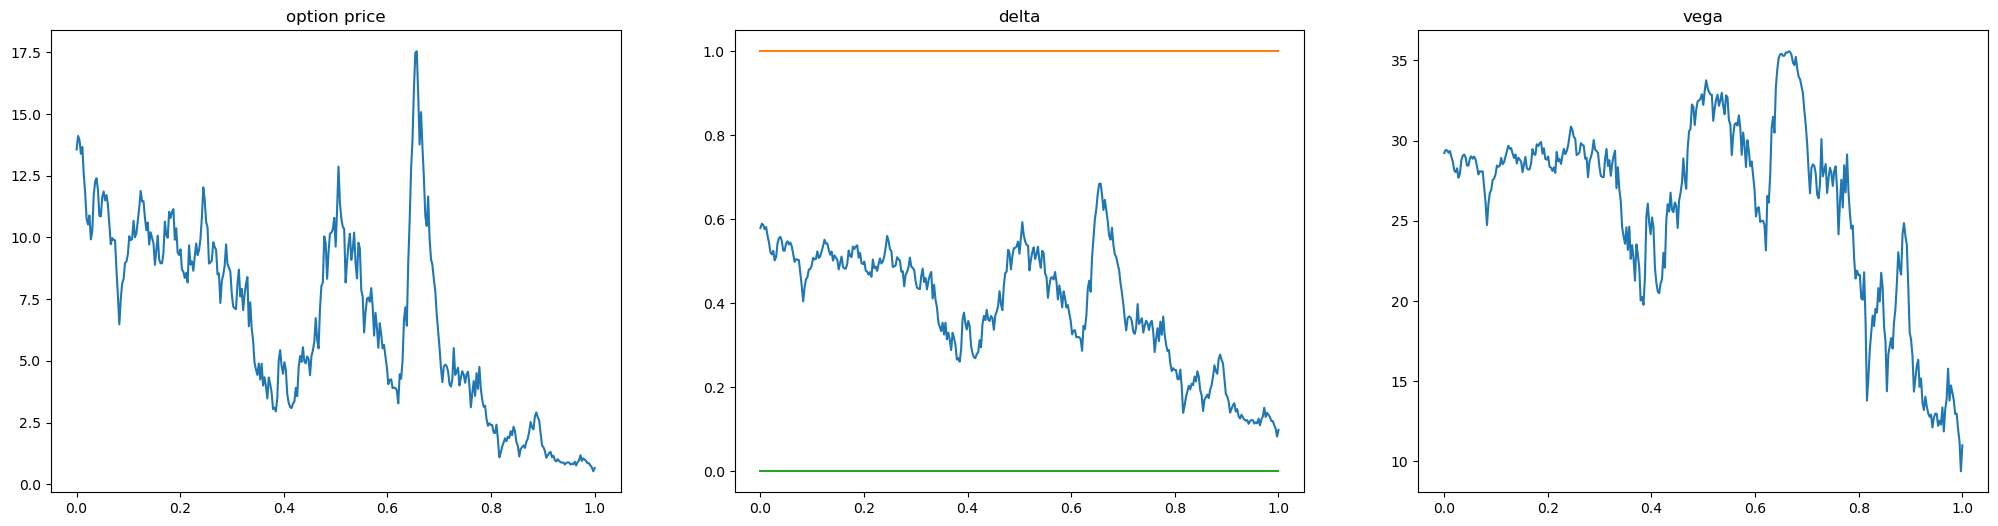

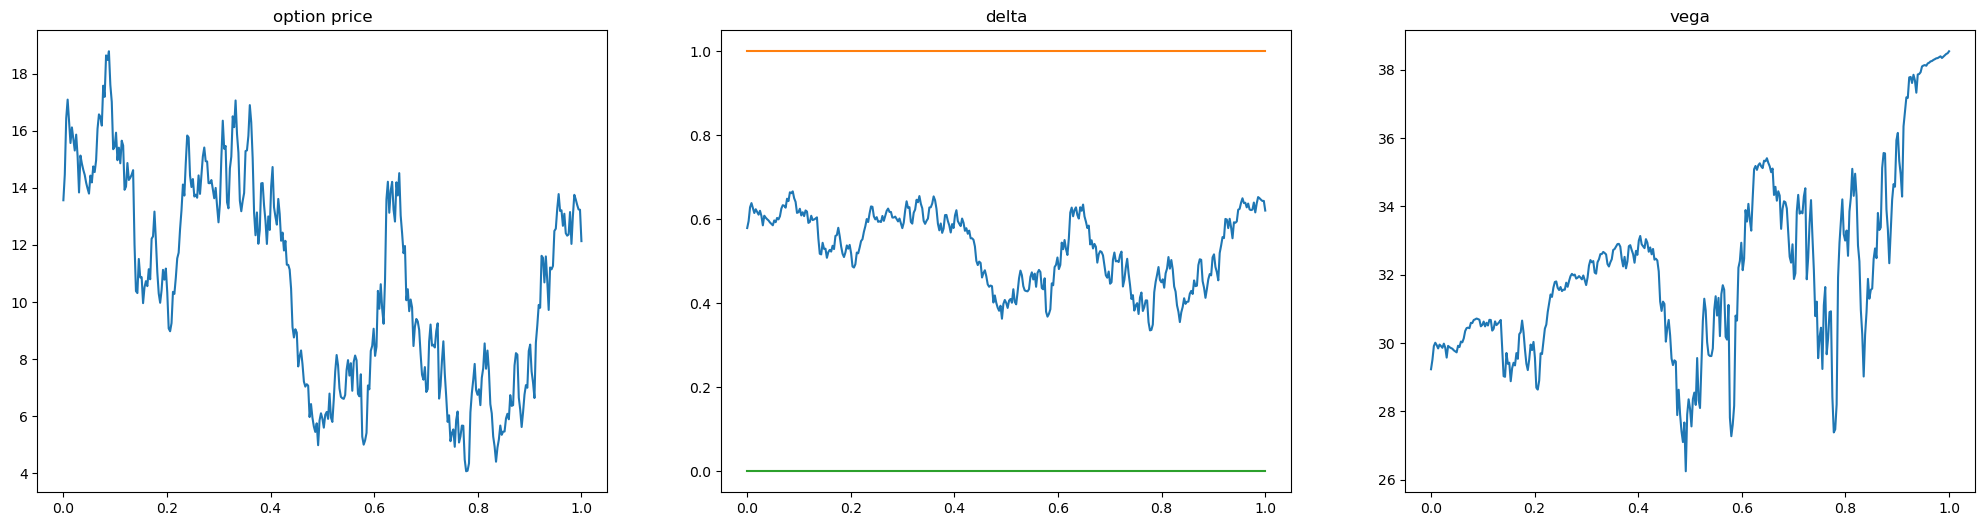

In [ ]:
for i in range(2):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (25, 6))
    axs[0].set_title('option price')
    axs[1].set_title('delta')
    axs[2].set_title('vega')
    axs[0].plot(t, option_price_paths_1[i, :])
    axs[1].plot(t, option_delta_paths_1[i, :])
    axs[1].plot([t[0], t[-1]], [1, 1])
    axs[1].plot([t[0], t[-1]], [0, 0])
    axs[2].plot(t, option_vega_paths_1[i, :])
    plt.show()

In [ ]:
#Delta
def delta_hedge(k):
    m = int(T//(k*dt))
    rebalance_times = np.linspace(0, m*k*dt, m+1)
    pnl = np.zeros((N_paths, m+1+1))
    pnl[:, 0] = option_price_paths_0[:, 0] - option_delta_paths_0[:, 0]*price_paths[:, 0]
    for i in range(1, m+1):
        pnl[:, i] = pnl[:, i-1]*np.exp(r*k*dt) - (option_delta_paths_0[:, i*k] - option_delta_paths_0[:, k*(i-1)])*price_paths[:, k*i]
    pnl[:, m+1] = pnl[:, m]*np.exp(r*(T-rebalance_times[-1])) - option_price_paths_0[:, -1] + option_delta_paths_0[:, i*k]*price_paths[:, -1]
    return pnl, pnl[:, -1].mean(), pnl[:, -1].var()

def delta_sigma_hedge(k):
    m = int(T//(k*dt))
    rebalance_times = np.linspace(0, m*k*dt, m+1) #include everything but the last point T
    pnl = np.zeros((N_paths, m+1+1))
    tmp2 = option_vega_paths_0/option_vega_paths_1
    tmp1 = option_delta_paths_0 - tmp2*option_delta_paths_1
    pnl[:, 0] = option_price_paths_0[:, 0] - tmp1[:, 0]*price_paths[:, 0] - tmp2[:, 0]*option_price_paths_1[:, 0]

    for i in range(1, m+1):
        pnl[:, i] = pnl[:, i-1]*np.exp(r*k*dt) - (tmp1[:, k*i] - tmp1[:, k*(i-1)])*price_paths[:, k*i] - (tmp2[:, k*i] - tmp2[:, k*(i-1)])*option_price_paths_1[:, k*i]
    pnl[:, m+1] = pnl[:, m]*np.exp(r*(T - rebalance_times[-1])) - option_price_paths_0[:, -1] + tmp1[:, k*i]*price_paths[:, -1] + \
    tmp2[:, k*i]*option_price_paths_1[:, -1]
    return pnl, pnl[:, -1].mean(), pnl[:, -1].var()

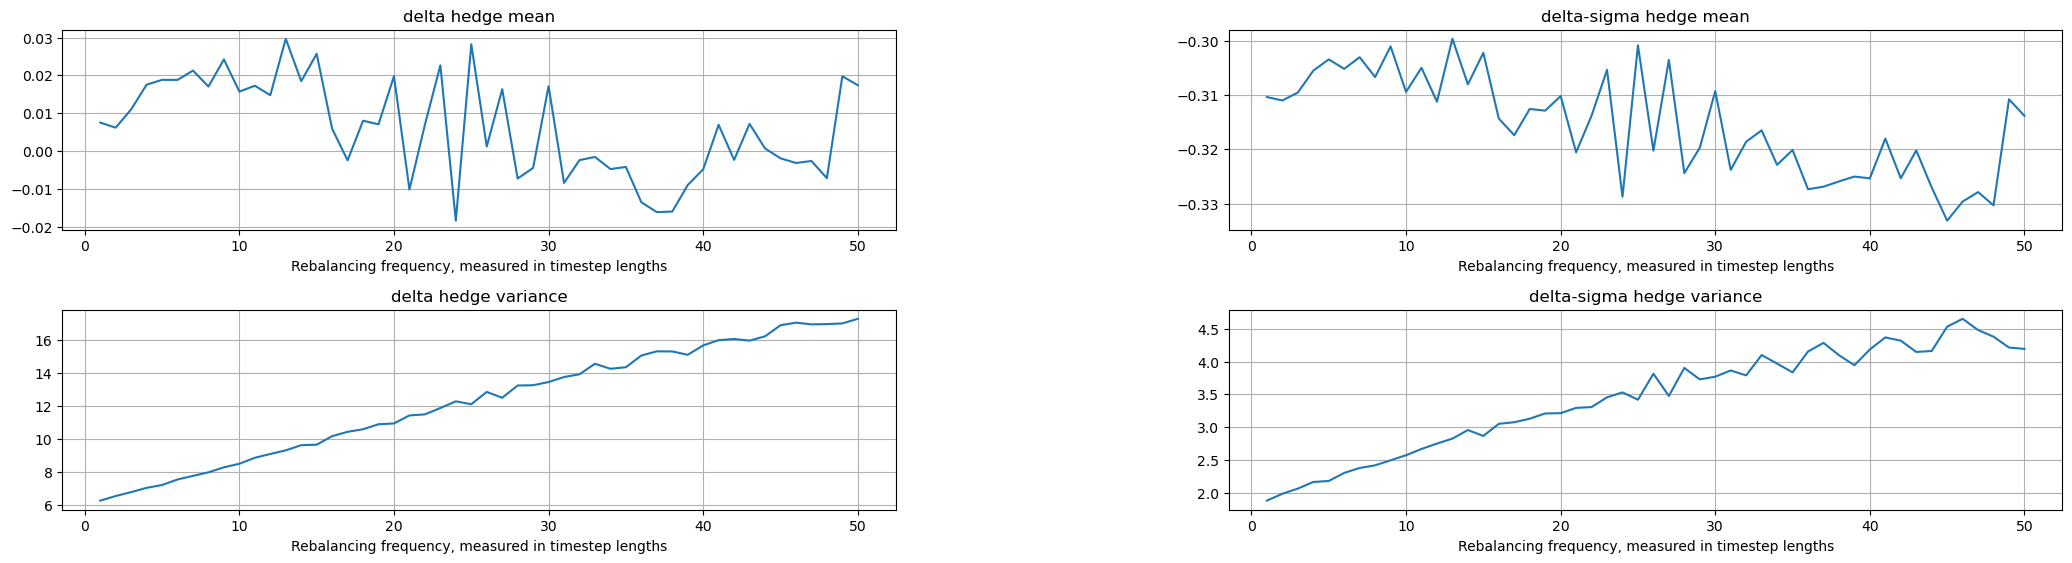

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (25, 6))
tmp = {0:'delta hedge', 1:'delta-sigma hedge'}
for i, method in enumerate([delta_hedge, delta_sigma_hedge]):
    axs[0, i].set_title(tmp[i] + ' mean')
    axs[1, i].set_title(tmp[i] + ' variance')
    k_max = 50
    mean = np.zeros(k_max)
    var = np.zeros(k_max)
    for k in range(1, k_max+1):
        _, mean[k-1], var[k-1] = method(k)
    axs[0, i].plot(np.arange(1, k_max+1), mean)
    axs[1, i].plot(np.arange(1, k_max+1), var)

for ax in axs.flat:
    ax.grid()
    ax.set_xlabel('Rebalancing frequency, measured in timestep lengths')

plt.subplots_adjust(
    left=0.1,    # left side of subplots
    right=0.9,   # right side of subplots
    bottom=0.1,  # bottom of subplots
    top=0.9,     # top of subplots
    wspace=0.4,  # horizontal space between subplots
    hspace=0.4   # vertical space between subplots
)

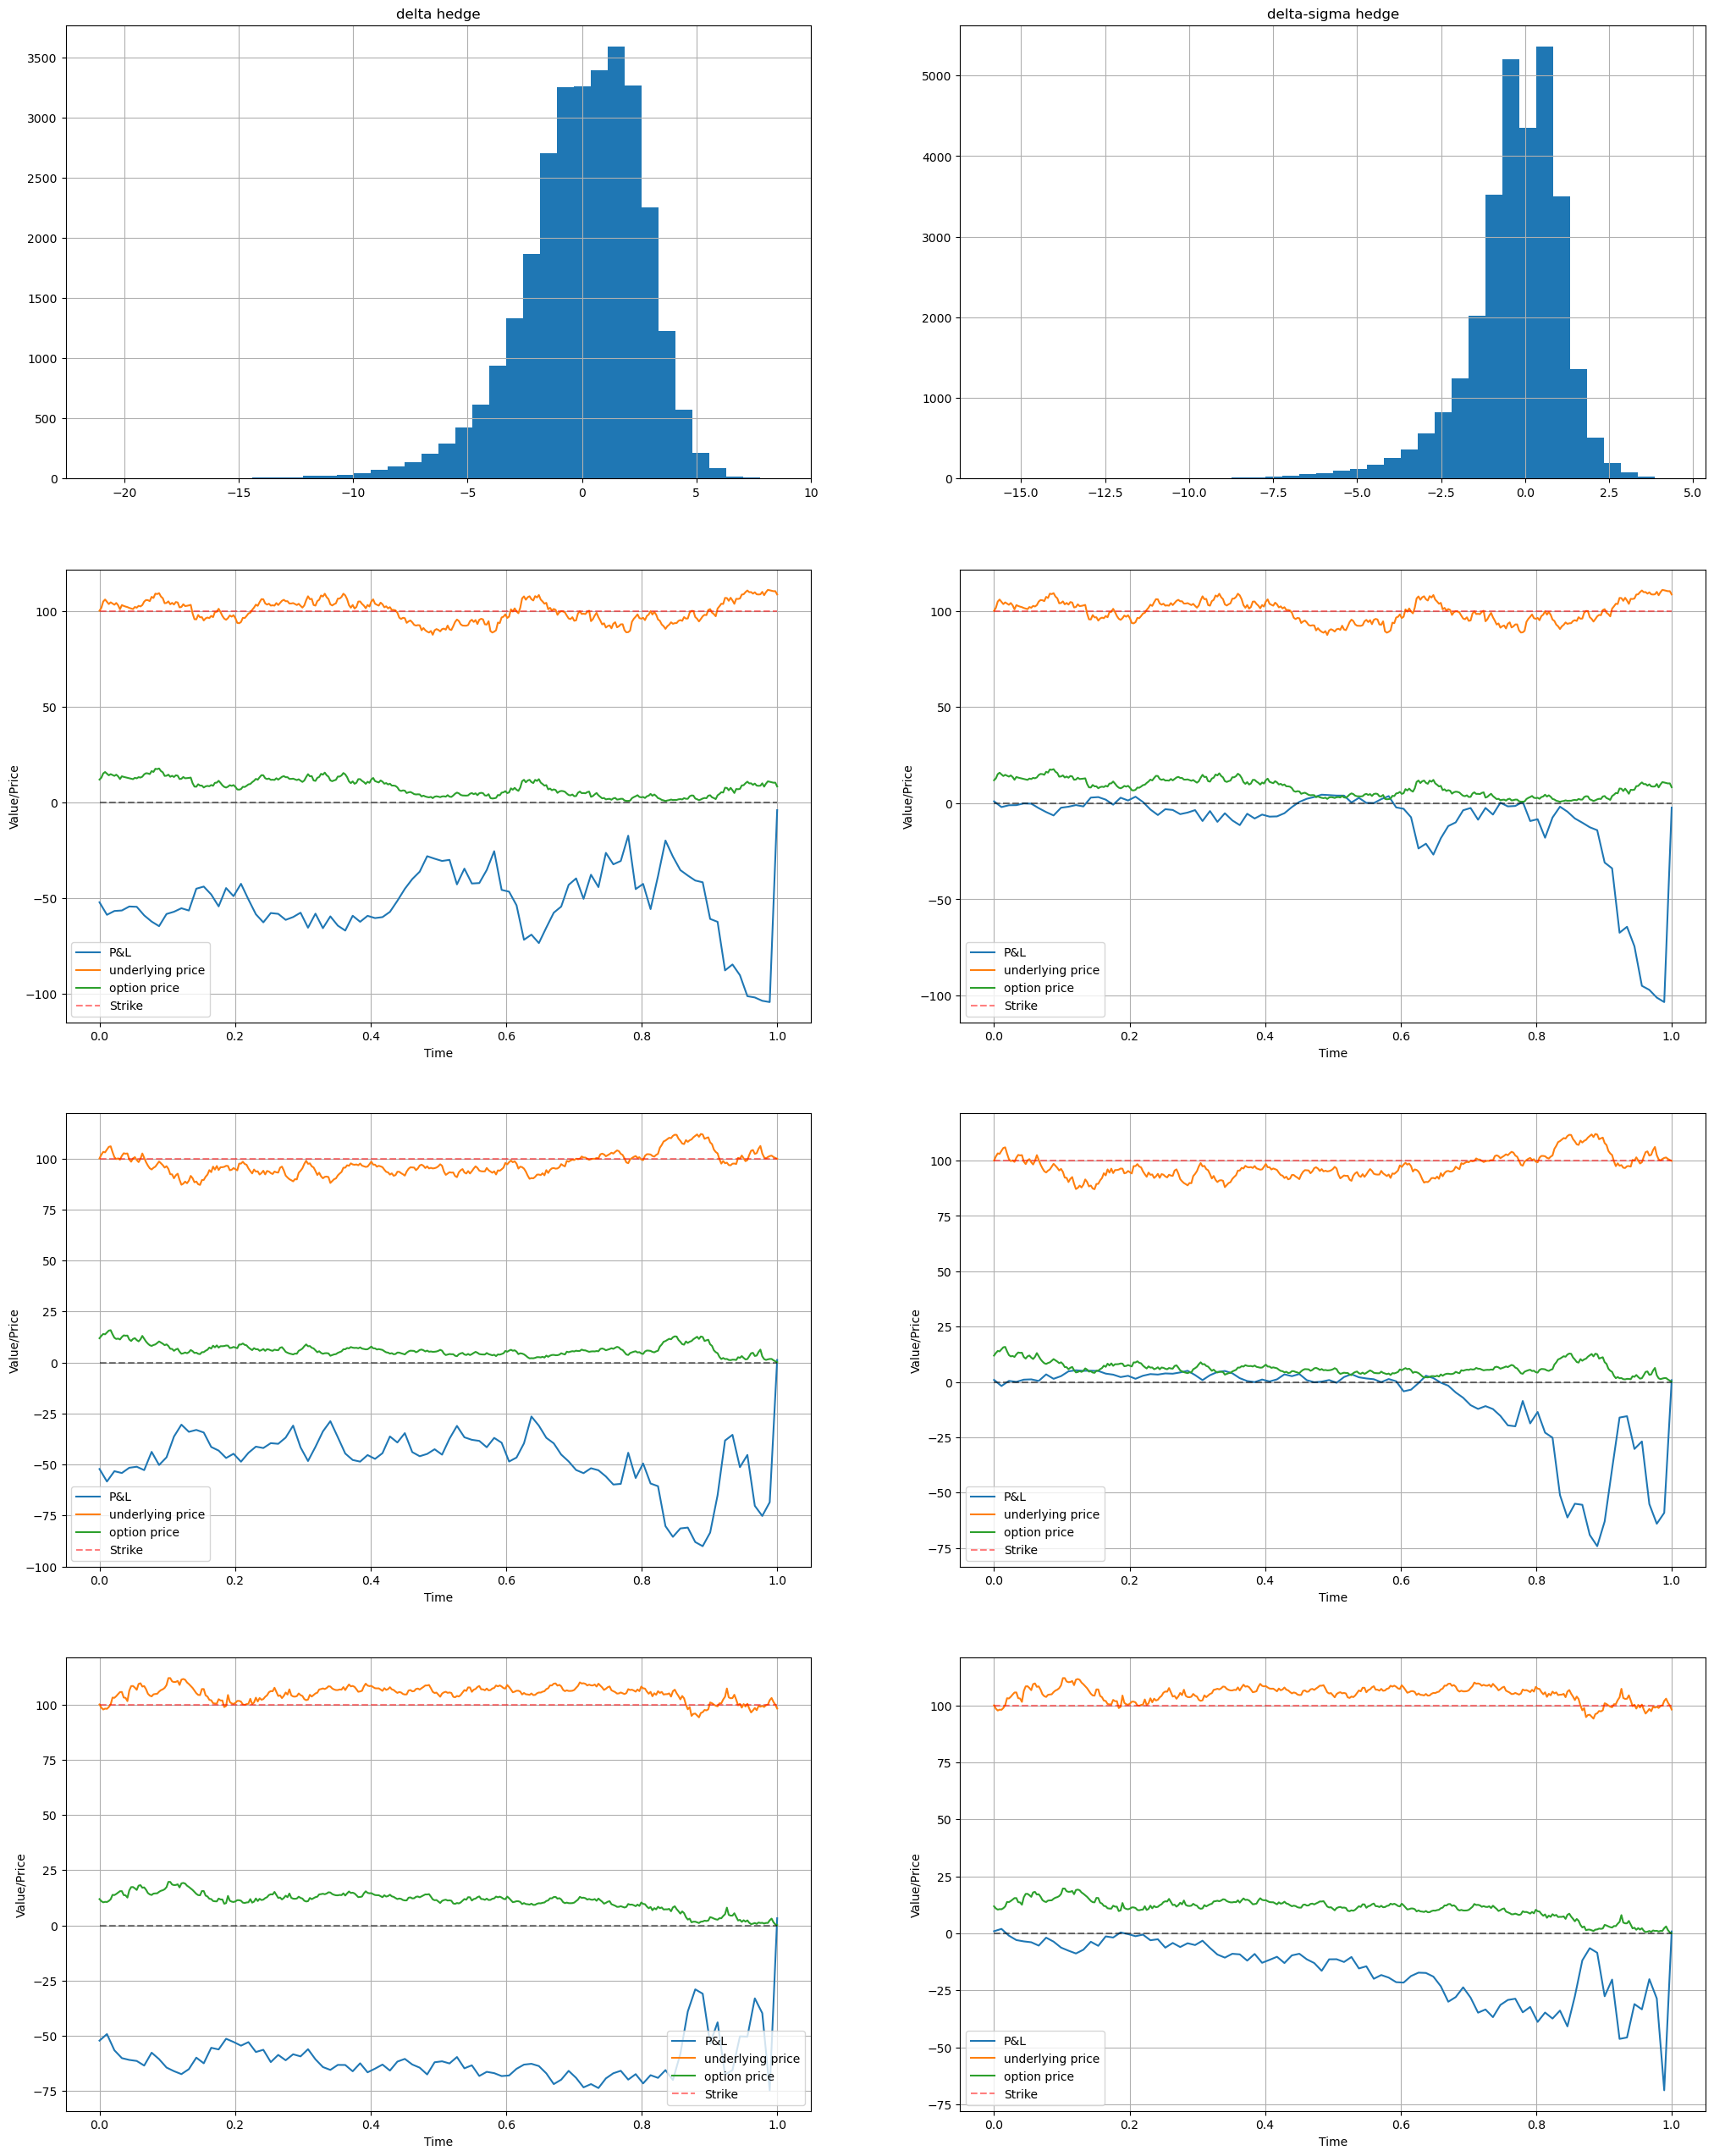

In [ ]:
tmp = {0:'delta hedge', 1:'delta-sigma hedge'}
k = 4
m = int(T//(k*dt))
rebalance_times = np.linspace(0, m*k*dt, m+1)
time = np.concatenate((rebalance_times, np.array(T).reshape(1, )))
n_exhibits = 3

fig,axs = plt.subplots(nrows = 1+n_exhibits, ncols = 2, figsize = (25, 8*(1+n_exhibits)))

for i, method in enumerate([delta_hedge, delta_sigma_hedge]):
    pnl, mean, var = method(k)
    axs[0, i].hist(pnl[:, -1], bins = 40)
    axs[0, i].set_title(tmp[i])
    axs[0, i].grid()

    for p in range(1, n_exhibits+1):
        axs[p, i].plot(time, pnl[p, :], label = "P&L")
        axs[p, i].plot(t, price_paths[p, :], label = 'underlying price')
        axs[p, i].plot(t, option_price_paths_0[p, :], label = 'option price')
        axs[p, i].plot([t[0], t[-1]], [K, K], label = 'Strike', c = 'red', alpha = 0.5, ls = '--')
        axs[p, i].plot([t[0], t[-1]], [0.0, 0.0], c = 'black', alpha = 0.5, ls = '--')
        axs[p, i].legend()
        axs[p, i].set_xlabel('Time')
        axs[p, i].set_ylabel('Value/Price')
        axs[p, i].grid()